<a href="https://colab.research.google.com/github/balvantchauhan/Deep-Learning/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's creates an image classifier using a keras.Sequential model, and loads data using preprocessing.image_dataset_from_directory. You will gain practical experience with the following concepts:

Efficiently loading a dataset off disk.
Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.
This tutorial follows a basic machine learning workflow:

Examine and understand data
Build an input pipeline
Build the model
Train the model
Test the model
Improve the model and repeat the process


### Import tensorflow and other libraries

In [274]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomRotation, RandomFlip, RandomZoom
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

flower_photo/ 
>daisy/<br>
  dandelion/<br>
  roses/<br>
  sunflowers/<br>
  tulips/

In [275]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [276]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

Here are some roses


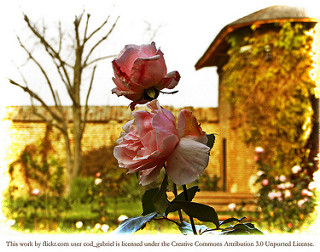

In [277]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

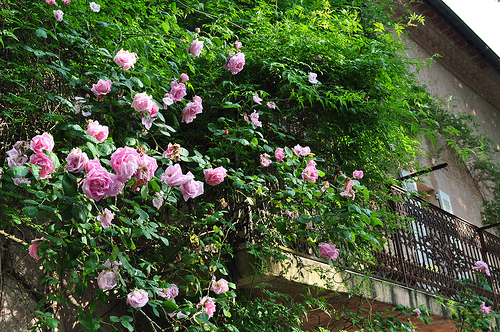

In [278]:
PIL.Image.open(str(roses[1]))

Here are some tulips

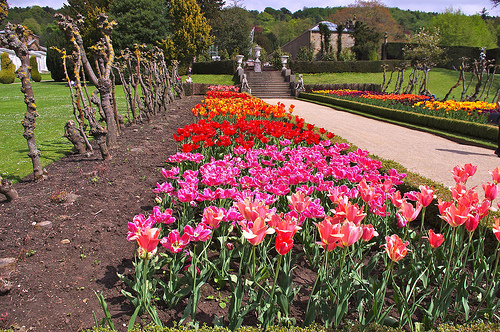

In [279]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

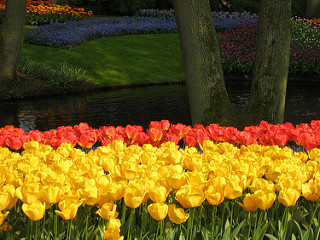

In [280]:
PIL.Image.open(str(tulips[1]))

### Create a dataset
Define some parameters for the loader:

In [281]:
BATCH_SIZE = 32
IMG_HEIGHT, IMG_WIDTH = 180, 180


It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [282]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [283]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [284]:
class_names = train_ds.class_names
print(class_name)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data
Here are the first 9 images from the training dataset

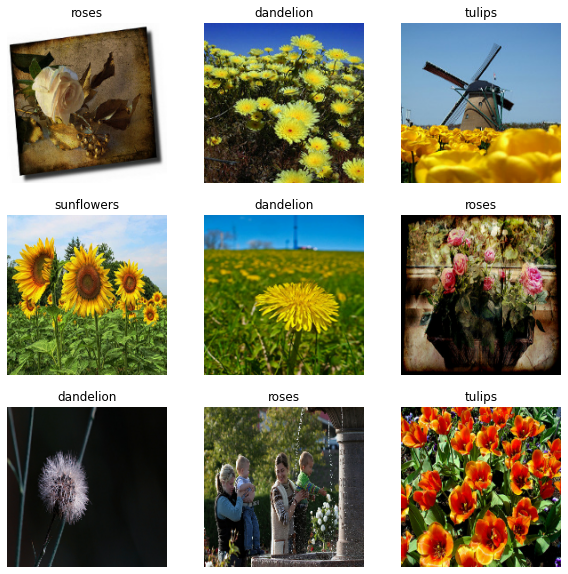

In [285]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

You will train a model using these datasets by passing them to model.fit in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [286]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [287]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.

We can also include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

### Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach.

In [288]:
num_classes = 5
model = Sequential()
model.add(RandomFlip('horizontal', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(RandomRotation(0.20))
model.add(RandomZoom(0.20))
model.add(Rescaling(1./255))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
#model.add(Dropout(0.1))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Here's the complete architecture of your model:

In [289]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_14 (RandomFlip)  (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_14 (RandomRo (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_14 (RandomZoom)  (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_14 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 90, 90, 32)      

### Compile the model

For this problem, we will use 'Adam' optimizer and 'SparseCategoricalCrossentropy' loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.

In [290]:
model.compile(optimizer='adam',
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
      )

### Train the model

In [291]:
EPOCHS = 15
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs=EPOCHS
          )

Epoch 1/15
92/92 [==============================] - 5s 23ms/step - loss: 1.3720 - accuracy: 0.4070 - val_loss: 1.1614 - val_accuracy: 0.5068
Epoch 2/15
92/92 [==============================] - 1s 16ms/step - loss: 1.0798 - accuracy: 0.5613 - val_loss: 1.0099 - val_accuracy: 0.6158
Epoch 3/15
92/92 [==============================] - 1s 16ms/step - loss: 0.9870 - accuracy: 0.6093 - val_loss: 0.9631 - val_accuracy: 0.6322
Epoch 4/15
92/92 [==============================] - 1s 16ms/step - loss: 0.9221 - accuracy: 0.6441 - val_loss: 0.8891 - val_accuracy: 0.6294
Epoch 5/15
92/92 [==============================] - 1s 16ms/step - loss: 0.8692 - accuracy: 0.6618 - val_loss: 0.8641 - val_accuracy: 0.6580
Epoch 6/15
92/92 [==============================] - 1s 16ms/step - loss: 0.8293 - accuracy: 0.6785 - val_loss: 0.8888 - val_accuracy: 0.6471
Epoch 7/15
92/92 [==============================] - 1s 16ms/step - loss: 0.7959 - accuracy: 0.6979 - val_loss: 0.7960 - val_accuracy: 0.6880
Epoch 8/15
92

### Visualize training results

Create plots of loss and accuracy on the training and validation sets.

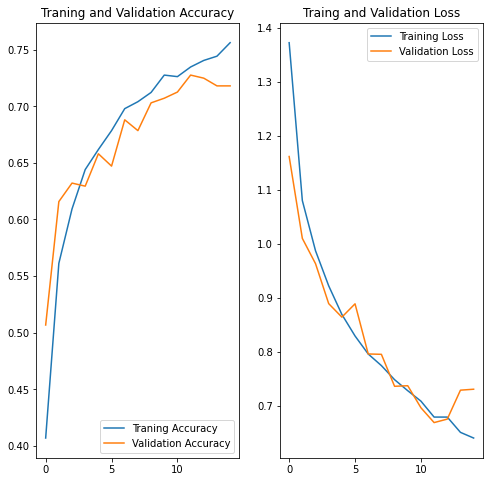

In [292]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Traning Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Traning and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label= 'Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Traing and Validation Loss')
plt.show()

### predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

In [293]:
sunflower_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
#img = PIL.Image.open('/content/daisies.jpeg')
#img = img.resize((IMG_HEIGHT, IMG_WIDTH))
img = tf.keras.preprocessing.image.load_img(sunflower_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
preds = model.predict(img_array)
print(preds)

[[1.8151682e-07 1.3798977e-03 3.4644767e-05 9.9728370e-01 1.3016250e-03]]


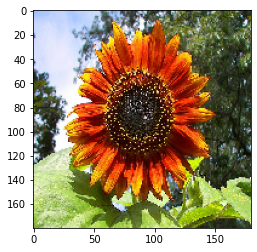

In [294]:
plt.imshow(img)

In [295]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(preds)], 100 * np.max(preds))
)

This image most likely belongs to sunflowers with a 99.73 percent confidence.
